In [ ]:
# !pip install timm
# !pip install wandb
# wandb login <wandb API>

In [1]:
import os
import time
import copy
from collections import OrderedDict

from tqdm import tqdm

import timm
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np

try:
    import wandb
except ImportError:
    wandb = None

In [2]:
# 対応モデルを確認
model_names = timm.list_models(pretrained=True)
model_names

['adv_inception_v3',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# base config
DATASET_PATH = './jpeg-512x512/'
BATCH_SIZE = 4
NUM_WORKERS = 2
NUM_FINETUNE_CLASSES = 104

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATASET_PATH, x),data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [15]:
class FlowerModel(nn.Module):
    def __init__(self,
                 n_classes,
                 model_name='tf_efficientnet_b5_ns',
                 use_fc=False,
                 fc_dim=512,
                 dropout=0.0,
                 s=30.0,
                 margin=0.50,
                 ls_eps=0.0,
                 theta_zero=0.785,
                 pretrained=True,
                 classification_checkpoint=None):
        
        super(FlowerModel, self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=n_classes)
        
        if classification_checkpoint:
            ckpt = torch.load(classification_checkpoint)
            self.backbone.load_state_dict(ckpt['weight'])
            print('loaded checkpoint weights!')            
            
        final_in_features = self.backbone.classifier.in_features
        
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()
        
        self.pooling =  nn.AdaptiveAvgPool2d(1)
            
        self.use_fc = use_fc
        if use_fc:
            self.dropout = nn.Dropout(p=dropout)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.final = nn.Linear(final_in_features, n_classes)

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x):
        feature = self.extract_feat(x)
        logits = self.final(feature)
        return logits

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        x = self.pooling(x).view(batch_size, -1)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)

        return x

# 画像分類

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, start_epoch=0):
    # wandb
    if wandb is not None and WANDB:
        wandb.init(
            project="Flower_Classification",
            config={
                'start_epoch' : START_EPOCH,
                'epochs' : EPOCHS,
                'batch_size' : BATCH_SIZE,
                'model' : MODEL_NAME,
                'checkpoint' : CKPT,
                'lr' : LR,
                'step_size' : STEP_SIZE,
                'dataset' : DATASET_PATH
            }
        )
    
    since = time.time()
    
    best_acc = 0.0
    
    # エポック
    for epoch in range(start_epoch, start_epoch+num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # train, value
        for phase in ['train', 'val']:
            print(f'Phase: {phase}')
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # バッチずつ
            with tqdm(dataloaders[phase]) as pbar:
                for i, (inputs, labels) in enumerate(pbar):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0) # バッチ数でかける
                    running_corrects += torch.sum(preds == labels.data).item()
                    pbar.set_postfix(OrderedDict(loss=loss.item(), acc=torch.sum(preds == labels.data).item()/4))
                    
                    # wandb
                    if phase == 'train' and wandb and WANDB:
                        wandb.log(
                            {
                                "loss/train": loss.item(),
                                "acc/train": torch.sum(preds == labels.data).item()/4,
                            }
                        )
                    elif phase == 'val' and wandb and WANDB:
                        wandb.log(
                            {
                                "loss/val": loss.item(),
                                "acc/val": torch.sum(preds == labels.data).item()/4,
                            }
                        )

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # wandb
            if phase == 'train' and wandb and WANDB:
                wandb.log(
                    {
                        "epoch_loss/train": epoch_loss,
                        "epoch_acc/train": epoch_acc,
                    }
                )
            elif phase == 'val' and wandb and WANDB:
                wandb.log(
                    {
                        "epoch_loss/val": epoch_loss,
                        "epoch_acc/val": epoch_acc,
                    }
                )
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save({'weight':model.state_dict(),
                           'optimizer':optimizer.state_dict(),
                           'scheduler':scheduler.state_dict()},
                           os.path.join(OUTPUT_PATH, f"{MODEL_NAME}_best.pth"))
                best_epoch = epoch+1

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    print(f'Best Epoch: {best_epoch}')
    
    if wandb is not None and WANDB:
        wandb.finish()

## 学習

In [ ]:
START_EPOCH = 0
EPOCHS = 10
BATCH_SIZE = 4
NUM_WORKERS = 2
NUM_FINETUNE_CLASSES = 104

LR = 0.001
STEP_SIZE = 5

WANDB = True

MODEL_NAME = 'tf_efficientnet_b5_ns'
CKPT = None

OUTPUT_PATH = f'./output/{MODEL_NAME}/'

os.makedirs(OUTPUT_PATH, exist_ok=True)

model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=NUM_FINETUNE_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=STEP_SIZE, gamma=0.1)

model.to(device)   

if CKPT:
    ckpt = torch.load(CKPT)
    model.load_state_dict(ckpt['weight'])
    optimizer_ft.load_state_dict(ckpt['optimizer'])
    exp_lr_scheduler.load_state_dict(ckpt['scheduler'])
    print('loaded checkpoint!')
    
train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCHS, start_epoch=START_EPOCH)

  0%|          | 0/3189 [00:00<?, ?it/s]

Epoch 1/10
----------
Phase: train


 66%|██████▌   | 2108/3189 [07:50<04:02,  4.45it/s, loss=0.511, acc=1]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 1.6580 Acc: 0.6215
Phase: val


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.5440 Acc: 0.8723
Phase: val


 44%|████▍     | 407/928 [00:32<00:41, 12.65it/s, loss=0.00693, acc=1] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 93%|█████████▎| 2970/3189 [11:03<00:49,  4.46it/s, loss=0.00187, acc=1] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.2080 Acc: 0.9523
Phase: val


100%|██████████| 928/928 [01:14<00:00, 12.39it/s, loss=0.414, acc=0.75]


val Loss: 0.2272 Acc: 0.9494


  0%|          | 0/3189 [00:00<?, ?it/s]


Epoch 5/10
----------
Phase: train


  7%|▋         | 238/3189 [00:53<10:59,  4.47it/s, loss=0.0238, acc=1]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 90%|████████▉ | 2866/3189 [10:41<01:12,  4.47it/s, loss=0.0166, acc=1]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.2314 Acc: 0.9472

Epoch 6/10
----------
Phase: train


 60%|██████    | 1915/3189 [07:08<04:45,  4.46it/s, loss=0.0126, acc=1]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0885 Acc: 0.9809
Phase: val


100%|██████████| 928/928 [01:15<00:00, 12.33it/s, loss=0.000795, acc=1]


val Loss: 0.2161 Acc: 0.9510


  0%|          | 0/3189 [00:00<?, ?it/s]


Epoch 7/10
----------
Phase: train


 52%|█████▏    | 1674/3189 [06:14<05:37,  4.49it/s, loss=0.0192, acc=1]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0718 Acc: 0.9858
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.2205 Acc: 0.9504

Epoch 8/10
----------
Phase: train


 23%|██▎       | 745/3189 [02:47<09:02,  4.50it/s, loss=0.00482, acc=1] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0750 Acc: 0.9847
Phase: val


 67%|██████▋   | 622/928 [00:50<00:24, 12.57it/s, loss=0.00574, acc=1] 

## 再学習

In [14]:
START_EPOCH = 10
EPOCHS = 10

LR = 0.001
STEP_SIZE = 5

WANDB = True

MODEL_NAME = 'tf_efficientnet_b5_ns'
CKPT = './output/tf_efficientnet_b5_ns/tf_efficientnet_b5_ns_best.pth'

OUTPUT_PATH = f'./output/{MODEL_NAME}/'

os.makedirs(OUTPUT_PATH, exist_ok=True)

model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=NUM_FINETUNE_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=STEP_SIZE, gamma=0.1)

model.to(device)   

if CKPT:
    ckpt = torch.load(CKPT)
    model.load_state_dict(ckpt['weight'])
    optimizer_ft.load_state_dict(ckpt['optimizer'])
    exp_lr_scheduler.load_state_dict(ckpt['scheduler'])
    print('loaded checkpoint!')
    
train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCHS, start_epoch=START_EPOCH)

loaded checkpoint!


  0%|          | 0/3189 [00:00<?, ?it/s]

Epoch 11/10
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0624 Acc: 0.9881
Phase: val


100%|██████████| 928/928 [01:15<00:00, 12.27it/s, loss=3.98e-5, acc=1] 


val Loss: 0.2166 Acc: 0.9526


  0%|          | 0/3189 [00:00<?, ?it/s]


Epoch 12/10
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0575 Acc: 0.9897
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.2135 Acc: 0.9523

Epoch 13/10
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0571 Acc: 0.9902
Phase: val


100%|██████████| 928/928 [01:13<00:00, 12.59it/s, loss=0.000151, acc=1]


val Loss: 0.2103 Acc: 0.9545


  0%|          | 0/3189 [00:00<?, ?it/s]


Epoch 14/10
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0608 Acc: 0.9887
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.2002 Acc: 0.9539

Epoch 15/10
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0541 Acc: 0.9907
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.2078 Acc: 0.9534

Epoch 16/10
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0522 Acc: 0.9911
Phase: val


100%|██████████| 928/928 [01:15<00:00, 12.35it/s, loss=0.0176, acc=1]  


val Loss: 0.2037 Acc: 0.9555


  0%|          | 0/3189 [00:00<?, ?it/s]


Epoch 17/10
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0587 Acc: 0.9906
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.2003 Acc: 0.9553

Epoch 18/10
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0558 Acc: 0.9899
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.2219 Acc: 0.9553

Epoch 19/10
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0576 Acc: 0.9900
Phase: val


100%|██████████| 928/928 [01:16<00:00, 12.16it/s, loss=0.0519, acc=1]  


val Loss: 0.2007 Acc: 0.9558


  0%|          | 0/3189 [00:00<?, ?it/s]


Epoch 20/10
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0572 Acc: 0.9904
Phase: val


  2%|▏         | 15/928 [00:01<01:19, 11.55it/s, loss=0.00447, acc=1] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# 距離学習

In [6]:
from pytorch_metric_learning.miners import TripletMarginMiner
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.losses import TripletMarginLoss
from pytorch_metric_learning.reducers import ThresholdReducer

In [7]:
def train_metric_model(model, losser, mininer, optimizer, scheduler, num_epochs=10, start_epoch=0):
    # wandb
    if wandb is not None and WANDB:
        wandb.init(
            project="Flower_Classification",
            config={
                'start_epoch' : START_EPOCH,
                'epochs' : EPOCHS,
                'batch_size' : BATCH_SIZE,
                'model' : MODEL_NAME,
                'checkpoint' : CKPT,
                'lr' : LR,
                'step_size' : STEP_SIZE,
                'dataset' : DATASET_PATH
            }
        )
    
    since = time.time()
    
    best_loss = 0.0
    
    # エポック
    for epoch in range(start_epoch, start_epoch+num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # train, value
        for phase in ['train', 'val']:
            print(f'Phase: {phase}')
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # バッチずつ
            with tqdm(dataloaders[phase]) as pbar:
                for i, (inputs, labels) in enumerate(pbar):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        embeddings = model(inputs)
                        indices_tuple = mininer(embeddings, labels)
                        loss = losser(embeddings, labels, indices_tuple)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0) # バッチ数でかける
                    pbar.set_postfix(OrderedDict(loss=loss.item(), n_mined_triplets=mininer.num_triplets))
                    
                    # wandb
                    if phase == 'train' and wandb and WANDB:
                        wandb.log(
                            {
                                "loss/train": loss,
                            }
                        )
                    elif phase == 'val' and wandb and WANDB:
                        wandb.log(
                            {
                                "loss/val": loss,
                            }
                        )

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # wandb
            if phase == 'train' and wandb and WANDB:
                wandb.log(
                    {
                        "epoch_loss/train": epoch_loss,
                    }
                )
            elif phase == 'val' and wandb and WANDB:
                wandb.log(
                    {
                        "epoch_loss/val": epoch_loss,
                    }
                )
            
            if phase == 'val' and epoch_loss > best_loss:
                best_loss = epoch_loss
                torch.save({'weight':model.state_dict(),
                           'optimizer':optimizer.state_dict(),
                           'scheduler':scheduler.state_dict()},
                           os.path.join(OUTPUT_PATH, f"{MODEL_NAME}_best.pth"))
                best_epoch = epoch+1

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f}')
    print(f'Best Epoch: {best_epoch}')
    
    if wandb is not None and WANDB:
        wandb.finish()

In [ ]:
START_EPOCH = 0
EPOCHS = 50
BATCH_SIZE = 4
NUM_WORKERS = 2
NUM_FINETUNE_CLASSES = 104

LR = 1e-4
STEP_SIZE = 5

WANDB = True

MODEL_NAME = 'tf_efficientnet_b5_ns'
CKPT = './output/tf_efficientnet_b5_ns/tf_efficientnet_b5_ns_best.pth'

model_params = {
    'n_classes':104,
    'model_name':MODEL_NAME,
    'use_fc':False,
    'fc_dim':512,
    'dropout':0.0,
    's':30.0,
    'margin':0.50,
    'ls_eps':0.0,
    'theta_zero':0.785,
    'pretrained':False,
    'classification_checkpoint':CKPT
}

OUTPUT_PATH = f'./output/metric/{MODEL_NAME}/'

os.makedirs(OUTPUT_PATH, exist_ok=True)


model = FlowerModel(**model_params)

distance = CosineSimilarity()
reducer = ThresholdReducer(low = 0)
losser = TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
miner = TripletMarginMiner(margin=0.2, distance=distance)

metric_optimizer = optim.Adam(model.parameters(), lr=LR)
metric_lr_scheduler = lr_scheduler.StepLR(metric_optimizer, step_size=10, gamma=0.1)

model.to(device)   
    
train_metric_model(model, losser, miner, metric_optimizer, metric_lr_scheduler, num_epochs=EPOCHS, start_epoch=START_EPOCH)

Building Model Backbone for tf_efficientnet_b5_ns model


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


loaded checkpoint weights!


wandb: Currently logged in as: hypknot (use `wandb login --relogin` to force relogin)


  0%|          | 0/3189 [00:00<?, ?it/s]

Epoch 1/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0288
Phase: val


100%|██████████| 928/928 [01:20<00:00, 11.56it/s, loss=0, n_mined_triplets=0]      


val Loss: 0.0223


  0%|          | 0/3189 [00:00<?, ?it/s]


Epoch 2/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0247
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.0217

Epoch 3/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0217
Phase: val


100%|██████████| 928/928 [01:19<00:00, 11.64it/s, loss=0.181, n_mined_triplets=2]  


val Loss: 0.0244


  0%|          | 0/3189 [00:00<?, ?it/s]


Epoch 4/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0211
Phase: val


100%|██████████| 928/928 [01:17<00:00, 11.96it/s, loss=0, n_mined_triplets=0]     


val Loss: 0.0255


  0%|          | 0/3189 [00:00<?, ?it/s]


Epoch 5/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0230
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.0235

Epoch 6/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0225
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.0188

Epoch 7/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0230
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.0205

Epoch 8/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0218
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.0240

Epoch 9/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0191
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.0189

Epoch 10/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0211
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.0189

Epoch 11/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0202
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.0186

Epoch 12/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0185
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.0244

Epoch 13/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0165
Phase: val


100%|██████████| 928/928 [01:20<00:00, 11.56it/s, loss=0, n_mined_triplets=0]     


val Loss: 0.0262


  0%|          | 0/3189 [00:00<?, ?it/s]


Epoch 14/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0184
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.0157

Epoch 17/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0186
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.0206

Epoch 18/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0196
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.0208

Epoch 19/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0159
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.0195

Epoch 20/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0183
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.0215

Epoch 21/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0171
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.0204

Epoch 22/50
----------
Phase: train


  0%|          | 0/928 [00:00<?, ?it/s]

train Loss: 0.0161
Phase: val


  0%|          | 0/3189 [00:00<?, ?it/s]

val Loss: 0.0215

Epoch 23/50
----------
Phase: train


 15%|█▌        | 491/3189 [02:06<11:27,  3.92it/s, loss=0, n_mined_triplets=0]       

In [36]:
model

FlowerModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track

## 特徴量抽出

In [5]:
def feature_extraction(model, dataloader):
    since = time.time()
    
    best_loss = 0.0
    
    model.eval()   

    _predicted_metrics = []
    _true_labels = []

    # バッチずつ
    for i, (inputs, labels) in tqdm(enumerate(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            metric = model(inputs).detach().cpu().numpy()
            metric = metric.reshape(metric.shape[0], metric.shape[1])
            _predicted_metrics.append(metric)
            _true_labels.append(labels.detach().cpu().numpy())

    print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    return np.concatenate(_predicted_metrics), np.concatenate(_true_labels)

In [16]:
MODEL_NAME = 'tf_efficientnet_b5_ns'
CKPT = './output/metric/tf_efficientnet_b5_ns/tf_efficientnet_b5_ns_best.pth'

model_params = {
    'n_classes':104,
    'model_name':MODEL_NAME,
    'use_fc':False,
    'fc_dim':512,
    'dropout':0.0,
    's':30.0,
    'margin':0.50,
    'ls_eps':0.0,
    'theta_zero':0.785,
    'pretrained':False
}

OUTPUT_PATH = f'./output/metric/{MODEL_NAME}/'

os.makedirs(OUTPUT_PATH, exist_ok=True)

model = FlowerModel(**model_params)
     
ckpt = torch.load(CKPT)
model.load_state_dict(ckpt['weight'])
print('loaded checkpoint weights!')   

model.to(device)   
    
predicted_metrics, labels = feature_extraction(model, dataloaders['val'])

Building Model Backbone for tf_efficientnet_b5_ns model
loaded checkpoint weights!


928it [00:53, 17.26it/s]


Training complete in 0m 54s


### dfに出力

In [21]:
import pandas as pd

In [33]:
label_names = [class_names_val[label] for label in labels]

In [34]:
df = pd.DataFrame(predicted_metrics, columns=[f'feat_{i}' for i in range(len(predicted_metrics[0]))])
df['label'] = label_names

In [35]:
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_95,feat_96,feat_97,feat_98,feat_99,feat_100,feat_101,feat_102,feat_103,label
0,-0.800802,-6.686755,2.291890,-6.562728,7.745037,6.728537,-2.491809,-4.484881,-2.737143,7.932643,...,-7.565012,5.332066,0.745956,2.969701,2.638199,7.016939,7.624356,2.285954,-4.529178,foxglove
1,-1.062384,-9.090408,2.106473,-8.307278,10.665771,9.068426,-3.133069,-5.898288,-2.975612,10.400145,...,-10.275208,7.315140,0.826239,4.833378,2.779420,9.377540,10.458584,2.551416,-6.206422,passion flower
2,-0.133140,-5.564013,7.093954,-6.700411,5.081787,4.433008,-3.458238,-2.864730,-3.854272,7.458284,...,-3.598590,2.709342,1.422618,0.412841,4.528669,3.052601,4.200697,3.536117,-2.623990,common tulip
3,-1.015239,-8.601444,2.186274,-7.964367,10.071804,8.585188,-2.997392,-5.624932,-2.950619,9.911002,...,-9.716297,6.910458,0.792586,4.439338,2.776150,8.899710,9.868609,2.506100,-5.837726,silverbush
4,0.895515,-3.159792,2.894783,-3.287399,1.636786,2.641953,-2.551905,-1.621515,-3.864995,3.834533,...,-2.033193,0.238001,2.521177,-1.292326,3.004183,2.188133,1.812453,1.697163,-2.271131,common dandelion


In [39]:
df['label'].value_counts()

iris                        228
wild rose                   216
wild geranium               205
common dandelion            164
sunflower                   134
                           ... 
prince of wales feathers      6
moon orchid                   5
alpine sea holly              5
siam tulip                    5
bolero deep blue              5
Name: label, Length: 104, dtype: int64


In [41]:
mean_metrics = df.groupby('label').mean()

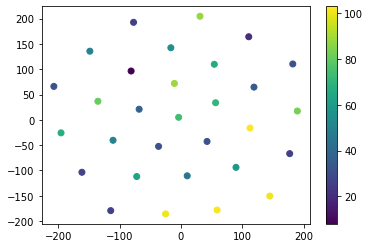

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tSNE_metrics = TSNE(n_components=2, random_state=0).fit_transform(predicted_metrics[:30])

plt.scatter(tSNE_metrics[:, 0], tSNE_metrics[:, 1], c=labels[:30])
plt.colorbar()
plt.show()